In [4]:
#!/home/big-dama/anaconda3/bin/python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from skfeature.function.similarity_based import lap_score
from skfeature.function.similarity_based import SPEC
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
%matplotlib inline

In [27]:
# the dataset contains 198 features extracted from NII Tokyo MAWI traces
dataset_loc = ('datasets/mawi_features_052016_thesis.csv')
dataset =  pd.read_csv(dataset_loc, index_col=False)
dataset.drop(columns=['table_name'],inplace=True)

In [15]:
unique_stats = dataset.std().to_frame().rename(columns = {'index': 'feature', 0: 'std'})
unique_stats = unique_stats.sort_values('std', ascending = True)
# Find the columns with zero variance
record_single_unique = pd.DataFrame(unique_stats[unique_stats['std'] == 0]).reset_index().rename(columns = {'index': 'feature', 0: 'std'})
print('%d features with a single unique value.\n' % len(record_single_unique))

14 features with a single unique value.



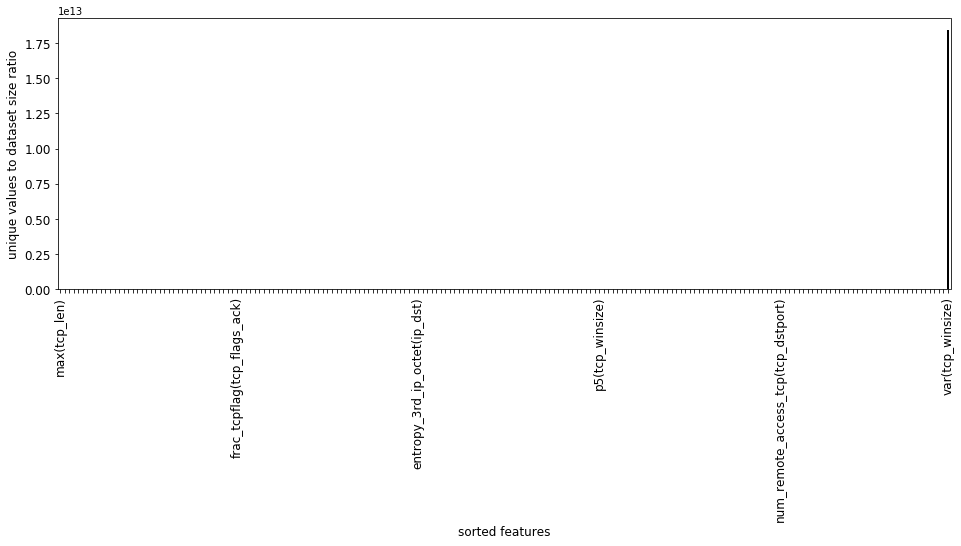

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(16, 5))
bar_plot = unique_stats.plot.bar(ax=ax, legend=False, color ='black', width=0.6)
ax.tick_params(labelsize=12)
for i, t in enumerate(ax.get_xticklabels()):
    if i not in [0,39,79,119,159,196]:
        t.set_visible(False)
ax.set_xlabel('sorted features',size=12)
ax.set_ylabel('unique values to dataset size ratio',size=12)
fig.savefig('plots/mawi_feature_variance.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)

In [22]:
dataset_corr = dataset[unique_stats.index.values].corr()
correlation_threshold = 1.0
upper = dataset_corr.where(np.triu(np.ones(dataset_corr.shape), k = 1).astype(np.bool))
# Select the features with correlations above the threshold
# Need to use the absolute value
to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]

In [23]:
# Dataframe to hold correlated pairs
dataset_collinear = pd.DataFrame(columns = ['drop_feature', 'corr_feature', 'corr_value'])

# Iterate through the columns to drop to record pairs of correlated features
for column in to_drop:

    # Find the correlated features
    corr_features = list(upper.index[upper[column].abs() > correlation_threshold])

    # Find the correlated values
    corr_values = list(upper[column][upper[column].abs() > correlation_threshold])
    drop_features = [column for _ in range(len(corr_features))]    

    # Record the information (need a temp df for now)
    temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,
                                     'corr_feature': corr_features,
                                     'corr_value': corr_values})
    dataset_collinear = dataset_collinear.append(temp_df, ignore_index = True)
    
dataset_corr_filtered = dataset_corr.loc[list(set(dataset_collinear['corr_feature'])), list(set(dataset_collinear['drop_feature']))]    

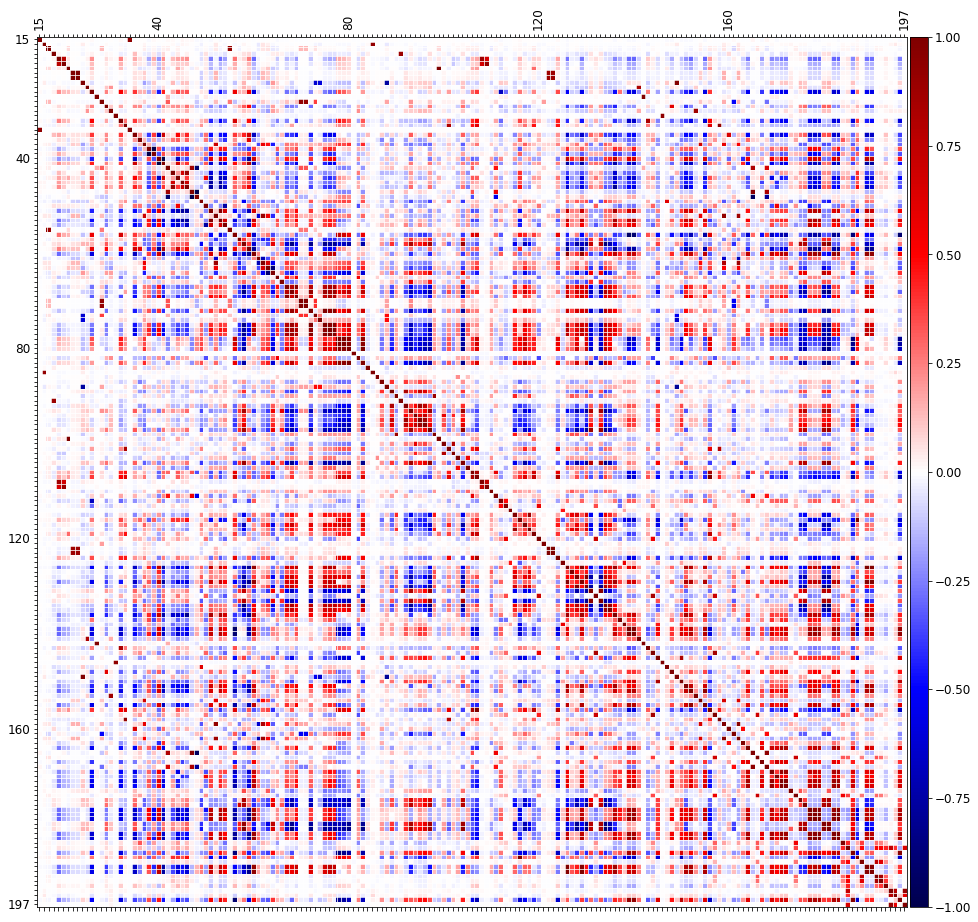

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(16, 16))
from mpl_toolkits.axes_grid1 import make_axes_locatable
#fig.suptitle('MAWI correlation matrix above threshold = ' + str(correlation_threshold), size=20)

dataset_corr_filtered = dataset_corr.iloc[14:,14:].copy()
heatmap = ax.matshow(dataset_corr_filtered, cmap=plt.cm.seismic)
ax.set_xticks(range(dataset_corr_filtered.shape[1]))
#ax.set_xticklabels(dataset_corr_filtered.columns.values, fontsize=10, rotation=90)
ax.set_xticklabels(np.arange(15,198), fontsize=12, rotation=90)
ax.set_yticks(range(dataset_corr_filtered.shape[0]))
#ax.set_yticklabels(dataset_corr_filtered.index.values, fontsize=10)
ax.set_yticklabels(np.arange(15,198), fontsize=12)

ax.set_xticks(np.arange(-.5, dataset_corr_filtered.shape[1]-1, 1), minor=True);
ax.set_yticks(np.arange(-.5, dataset_corr_filtered.shape[0]-1, 1), minor=True);
ax.grid(which='minor', color='w', linestyle='-', linewidth=0.75)

#plt.subplots_adjust(top=0.80)
for tic in ax.xaxis.get_minor_ticks():
    tic.tick1On = tic.tick2On = False
for tic in ax.yaxis.get_minor_ticks():
    tic.tick1On = tic.tick2On = False
for i, t in enumerate(ax.get_xticklabels()):
    if i not in [0,25,65,105,145,182]:
        t.set_visible(False)
for i, t in enumerate(ax.get_yticklabels()):
    if i not in [0,25,65,105,145,182]:
        t.set_visible(False)
        
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)

cb = fig.colorbar(heatmap, cax=cax)
cb.ax.tick_params(labelsize=12)
fig.savefig('plots/mawi_feature_colinearity.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)

In [4]:
# filter out 14 single values features
dataset.drop(columns=record_single_unique['feature'].values,inplace=True)

In [18]:
dataset_lap_score = lap_score.lap_score(dataset.values)

In [5]:
#feature_selection = pd.DataFrame(columns=['feature_selection_method','score','ranking'])
#feature_selection = feature_selection.append({'feature_selection_method' : 'lap_score','score' : dataset_lap_score,'ranking' : lap_score.feature_ranking(dataset_lap_score)}, ignore_index=True)
#feature_selection.to_pickle('mawi_feature_selection.csv')
feature_selection = pd.read_pickle('mawi_feature_selection.csv')

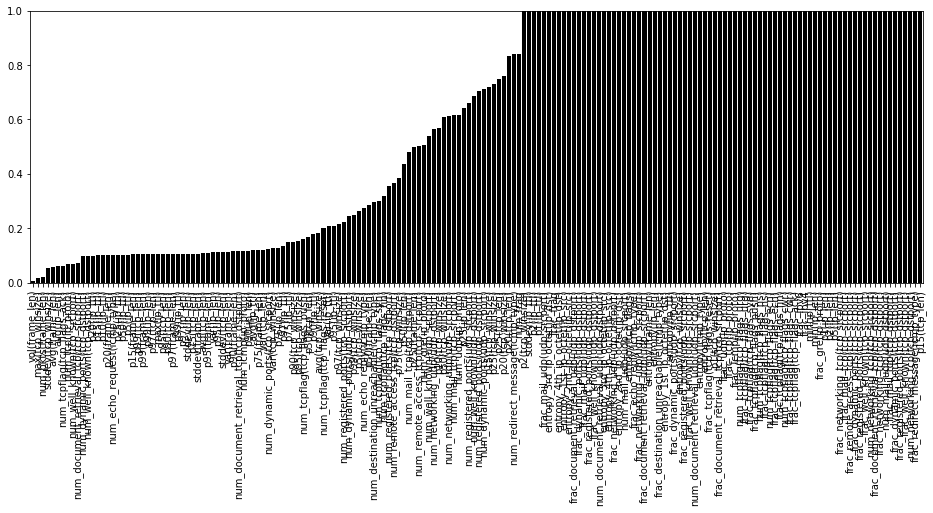

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(16, 5))
first = 0
last = 178
dataset_lap_score = feature_selection['score'][0]
ax.bar(np.arange(dataset.shape[1])[first:last],np.sort(dataset_lap_score)[first:last], color ='black', width=0.8)
ax.tick_params(labelsize=10)
ax.set_ylim([0,1])
ax.set_xlim([-0.5,last-first-0.5])
ax.set_xticks(np.arange(dataset.shape[1])[first:last])
labels = ax.set_xticklabels(dataset.columns.values[np.argsort(dataset_lap_score)][first:last], rotation=90)

In [39]:
feature_list = list(filter(lambda x: dataset_lap_score[x] < 1, range(len(dataset_lap_score)))) 
#feature_list = list(filter(lambda x: dataset_lap_score[x] < np.percentile(dataset_lap_score,50), range(len(dataset_lap_score)))) 
#dataset_lap_score
dataset.to_csv('datasets/mawi_features_052016_FsLapLess1.csv',columns=dataset.columns.values[feature_list],index=False)
dataset_test = pd.read_csv('datasets/mawi_features_052016_FsLapLess1.csv',index_col=False)

scaler = StandardScaler()
scaler.fit(dataset_test)
dataset_test_scaled = pd.DataFrame(scaler.transform(dataset_test),columns=dataset_test.columns)
dataset_test_scaled.to_csv('datasets/mawi_features_052016_FsLapLess1_StadardScaled.csv',index=False)

# DBSCAN for filtered dataset

In [52]:
dataset_test_scaled = pd.read_csv('datasets/mawi_features_052016_FsLapLessP10_StadardScaled.csv',index_col=False)

In [53]:
197-len(dataset_test_scaled.columns)

178

In [42]:
# rule of thumb 1 - minpts >=2*D ; number_of_neighbors = minpts-1 -> 2*D-1
n_nbrs1 = 2*len(dataset_test_scaled.columns.values) - 1
nbrs1 = NearestNeighbors(n_neighbors=n_nbrs1).fit(dataset_test_scaled.values)
distances1, indices1 = nbrs1.kneighbors(dataset_test_scaled.values)
# rule of thumb 2 : minpts >= D+1 ; number_of_neighbors = minpts-1 -> D
n_nbrs2 = len(dataset_test_scaled.columns.values)
nbrs2 = NearestNeighbors(n_neighbors=n_nbrs2).fit(dataset_test_scaled.values)
distances2, indices2 = nbrs2.kneighbors(dataset_test_scaled.values)

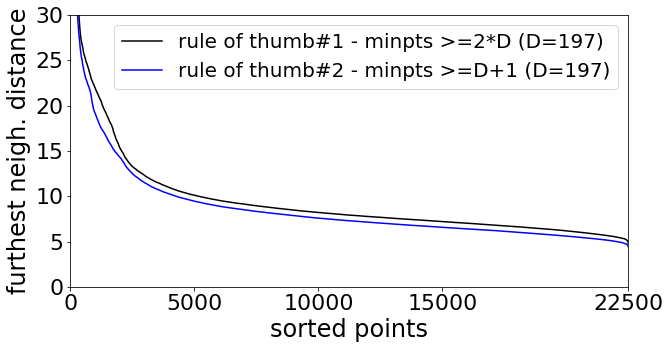

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(np.sort(distances1[:,n_nbrs1-1])[::-1], color='black')
ax.plot(np.sort(distances2[:,n_nbrs2-1])[::-1], color='blue')
ax.set_xlim([0,len(dataset_test_scaled)])
ax.set_ylim([0,30])

arr = np.sort(distances1[:,n_nbrs1-1])[::-1]
v_low = 5
v_high = 8
idx_low = (np.abs(arr - v_low)).argmin()
idx_high = (np.abs(arr - v_high)).argmin()

#ax.axhline(y=5, xmin=0, xmax=idx_low/len(arr),linestyle='--',color='black')
#ax.axhline(y=8, xmin=0, xmax=idx_high/len(arr),linestyle='--',color='black')
#ax.axvline(x=idx_low, ymin=0, ymax=v_low/30,linestyle='--',color='black')
#ax.axvline(x=idx_high, ymin=0, ymax=v_high/30,linestyle='--',color='black')

#ax.set_yticks(list(ax.get_yticks()) + [8])
ax.set_xticks([0,5000,10000,15000,22497])
ax.set_xticklabels(['0','5000','10000','15000','22500'])
ax.tick_params(labelsize=22)
ax.set_xlabel('sorted points',size=24)
ax.set_ylabel('furthest neigh. distance',size=24)

ax.legend(['rule of thumb#1 - minpts >=2*D (D=' + str(len(dataset_test_scaled.columns)) + ')'\
           ,'rule of thumb#2 - minpts >=D+1 (D=' + str(len(dataset_test_scaled.columns)) + ')'], fontsize=20)
fig.savefig('plots/mawi_all_k-dist_plots.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)

In [44]:
print('Feature selection : All features')
print('Rule of thumb#1 50th percentile: ' +str(np.percentile(distances1[:,n_nbrs1-1],50)))
print('Rule of thumb#1 90th percentile: ' +str(np.percentile(distances1[:,n_nbrs1-1],90)))
print('Rule of thumb#2 50th percentile: ' +str(np.percentile(distances2[:,n_nbrs2-1],50)))
print('Rule of thumb#2 90th percentile: ' +str(np.percentile(distances2[:,n_nbrs2-1],90)))

Feature selection : All features
Rule of thumb#1 50th percentile: 7.914232669563986
Rule of thumb#1 90th percentile: 14.121543968056315
Rule of thumb#2 50th percentile: 7.287367039484114
Rule of thumb#2 90th percentile: 13.268424203686408


In [48]:
print('Feature selection : Lap_score < 1')
print('Rule of thumb#1 50th percentile: ' +str(np.percentile(distances1[:,n_nbrs1-1],50)))
print('Rule of thumb#1 90th percentile: ' +str(np.percentile(distances1[:,n_nbrs1-1],90)))
print('Rule of thumb#2 50th percentile: ' +str(np.percentile(distances2[:,n_nbrs2-1],50)))
print('Rule of thumb#2 90th percentile: ' +str(np.percentile(distances2[:,n_nbrs2-1],90)))

Feature selection : Lap_score < 1
Rule of thumb#1 50th percentile: 5.099779562639164
Rule of thumb#1 90th percentile: 8.972353555551162
Rule of thumb#2 50th percentile: 4.729671414174853
Rule of thumb#2 90th percentile: 8.10412724171915


In [54]:
print('Feature selection : Lap_score < p50')
print('Rule of thumb#1 50th percentile: ' +str(np.percentile(distances1[:,n_nbrs1-1],50)))
print('Rule of thumb#1 90th percentile: ' +str(np.percentile(distances1[:,n_nbrs1-1],90)))
print('Rule of thumb#2 50th percentile: ' +str(np.percentile(distances2[:,n_nbrs2-1],50)))
print('Rule of thumb#2 90th percentile: ' +str(np.percentile(distances2[:,n_nbrs2-1],90)))

Feature selection : Lap_score < p50
Rule of thumb#1 50th percentile: 4.7029855804590435
Rule of thumb#1 90th percentile: 7.923898473341792
Rule of thumb#2 50th percentile: 4.346482074838394
Rule of thumb#2 90th percentile: 7.402570788428413


In [65]:
print('Feature selection : Lap_score < p25')
print('Rule of thumb#1 50th percentile: ' +str(np.percentile(distances1[:,n_nbrs1-1],50)))
print('Rule of thumb#1 90th percentile: ' +str(np.percentile(distances1[:,n_nbrs1-1],90)))
print('Rule of thumb#2 50th percentile: ' +str(np.percentile(distances2[:,n_nbrs2-1],50)))
print('Rule of thumb#2 90th percentile: ' +str(np.percentile(distances2[:,n_nbrs2-1],90)))

Feature selection : Lap_score < p25
Rule of thumb#1 50th percentile: 2.443996584312541
Rule of thumb#1 90th percentile: 4.057635609055259
Rule of thumb#2 50th percentile: 2.221528654687908
Rule of thumb#2 90th percentile: 3.6559499927978223


In [61]:
print('Feature selection : Lap_score < p10')
print('Rule of thumb#1 50th percentile: ' +str(np.percentile(distances1[:,n_nbrs1-1],50)))
print('Rule of thumb#1 90th percentile: ' +str(np.percentile(distances1[:,n_nbrs1-1],90)))
print('Rule of thumb#2 50th percentile: ' +str(np.percentile(distances2[:,n_nbrs2-1],50)))
print('Rule of thumb#2 90th percentile: ' +str(np.percentile(distances2[:,n_nbrs2-1],90)))

Feature selection : Lap_score < p10
Rule of thumb#1 50th percentile: 1.0115070836741789
Rule of thumb#1 90th percentile: 1.593732270635924
Rule of thumb#2 50th percentile: 0.9086171728898617
Rule of thumb#2 90th percentile: 1.4204761490496585


In [ ]:
dataset_spec_score = SPEC.spec(dataset.values)

In [25]:
feature_selection = pd.read_pickle('mawi_feature_selection.csv')
feature_selection = feature_selection.append({'feature_selection_method' : 'SPEC','score' : dataset_spec_score,'ranking' : SPEC.feature_ranking(dataset_spec_score)}, ignore_index=True)
feature_selection.to_pickle('mawi_feature_selection.csv')

# Evaluation

In [5]:
dbscan_results_df = pd.read_pickle('results/mawi_all_dbscan_results_df_eval_thesis.csv')

# some clustering results contained only 1 cluster - it does not make sense to evaluate clustering of 1 cluster
dbscan_results_df['Composed Density between and within clusters(cdbw)'].replace('NA',0,inplace=True)
dbscan_results_df['Composed Density between and within clusters(cohesion)'].replace('NA',0,inplace=True)
dbscan_results_df['Composed Density between and within clusters(compactness)'].replace('NA',0,inplace=True)
dbscan_results_df['Composed Density between and within clusters(sep)'].replace('NA',0,inplace=True)
dbscan_results_df['Density Based Clustering Validation(dbcv)'].replace('NA',-1,inplace=True)
dbscan_results_df.set_index(['eps'], inplace= True)

In [60]:
dbscan_results_df.index

Float64Index([ 0.1, 0.15,  0.2, 0.25,  0.3, 0.35,  0.4, 0.45,  0.5, 0.55,  0.6,
              0.65,  0.7, 0.75,  0.8, 0.85,  0.9, 0.95,  1.0, 1.05,  1.1, 1.15,
               1.2, 1.25,  1.3, 1.35,  1.4, 1.45,  1.5, 1.55,  1.6, 1.65,  1.7,
              1.75,  1.8, 1.85,  1.9, 1.95,  2.0, 2.05,  2.1, 2.15,  2.2, 2.25,
               2.3, 2.35,  2.4, 2.45,  2.5,  0.1, 0.15,  0.2, 0.25,  0.3, 0.35,
               0.4, 0.45,  0.5, 0.55,  0.6, 0.65,  0.7, 0.75,  0.8, 0.85,  0.9,
              0.95,  1.0, 1.05,  1.1, 1.15,  1.2, 1.25,  1.3, 1.35,  1.4, 1.45,
               1.5, 1.55,  1.6, 1.65,  1.7, 1.75,  1.8, 1.85,  1.9, 1.95,  2.0,
              2.05,  2.1, 2.15,  2.2, 2.25,  2.3, 2.35,  2.4, 2.45,  2.5],
             dtype='float64', name='eps')

In [13]:
#len(dbscan_results_df[dbscan_results_df['min_samples']==394].loc[14.0]['noise_index'])
dbscan_results_df[dbscan_results_df['min_samples']==394].loc[14.0]

min_samples                                                                                                394
labels                                                       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Composed Density between and within clusters(cdbw)                                                           0
Composed Density between and within clusters(cohesion)                                                       0
Composed Density between and within clusters(compactness)                                                    0
Composed Density between and within clusters(sep)                                                            0
Density Based Clustering Validation(dbcv)                                                                   -1
homogeneity(major clusters)                                                                        1.44753e-16
completeness(major clusters)                                                                                 1
v

In [64]:
dbscan_results_df[dbscan_results_df['min_samples']==20].loc[2.4]['Density Based Clustering Validation(dbcv)']

0.7356567908729322

Max DBCV for MinPts=394 (eps/value) :7.0/0.07927176668717323
Max DBCV for MinPts=198 (eps/value) :7.0/0.026324017868055574


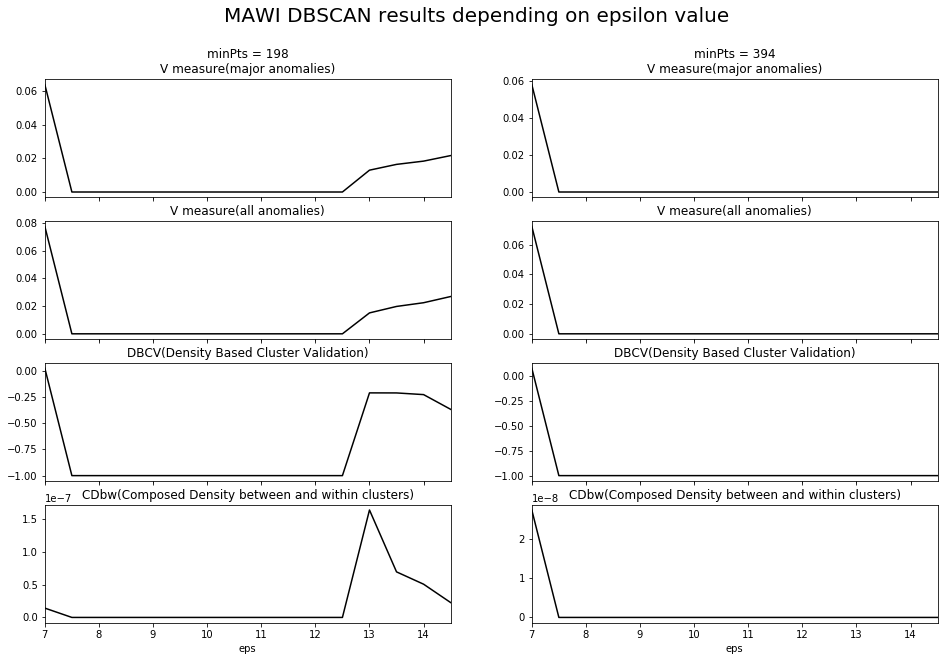

In [6]:
fig, ax = plt.subplots(4, 2, figsize=(16, 10))
fig.suptitle('MAWI DBSCAN results depending on epsilon value', size=20)

rule1 = dbscan_results_df['min_samples'].min()
rule2 = dbscan_results_df['min_samples'].max()
# clustering results for too low or too high values of Eps result in 1 cluster or noise and DBCV is 'NaN'; min value for DBCV is -1 -> replace('NaN', -1)
dbscan_results_df[dbscan_results_df['min_samples']==rule1]['v measure(major clusters)'].plot(kind='line',ax=ax[0,0],sharex=True,title='minPts = '+str(rule1)+'\nV measure(major anomalies)',color='black')
dbscan_results_df[dbscan_results_df['min_samples']==rule1]['v measure'].plot(kind='line',ax=ax[1,0],sharex=True,title='V measure(all anomalies)',color='black')
dbscan_results_df[dbscan_results_df['min_samples']==rule1]['Density Based Clustering Validation(dbcv)'].plot(kind='line',ax=ax[2,0],sharex=True,title='DBCV(Density Based Cluster Validation)',color='black')
dbscan_results_df[dbscan_results_df['min_samples']==rule1]['Composed Density between and within clusters(cdbw)'].plot(kind='line',ax=ax[3,0],sharex=True,title='CDbw(Composed Density between and within clusters)',color='black')

dbscan_results_df[dbscan_results_df['min_samples']==rule2]['v measure(major clusters)'].plot(kind='line',ax=ax[0,1],sharex=True,title='minPts = '+str(rule2)+'\nV measure(major anomalies)',color='black')
dbscan_results_df[dbscan_results_df['min_samples']==rule2]['v measure'].plot(kind='line',ax=ax[1,1],sharex=True,title='V measure(all anomalies)',color='black')
dbscan_results_df[dbscan_results_df['min_samples']==rule2]['Density Based Clustering Validation(dbcv)'].plot(kind='line',ax=ax[2,1],sharex=True,title='DBCV(Density Based Cluster Validation)',color='black')
dbscan_results_df[dbscan_results_df['min_samples']==rule2]['Composed Density between and within clusters(cdbw)'].plot(kind='line',ax=ax[3,1],sharex=True,title='CDbw(Composed Density between and within clusters)',color='black')

print('Max DBCV for MinPts='+str(rule2)+' (eps/value) :' + \
str(dbscan_results_df[dbscan_results_df['min_samples']==rule2]['Density Based Clustering Validation(dbcv)'].idxmax()) \
+'/'+ str(dbscan_results_df[dbscan_results_df['min_samples']==rule2]['Density Based Clustering Validation(dbcv)'].max()))

print('Max DBCV for MinPts='+str(rule1)+' (eps/value) :' + \
str(dbscan_results_df[dbscan_results_df['min_samples']==rule1]['Density Based Clustering Validation(dbcv)'].idxmax()) \
+'/'+ str(dbscan_results_df[dbscan_results_df['min_samples']==rule1]['Density Based Clustering Validation(dbcv)'].max()))